# Continuous Control with Multiple Agent DDPG

#### Start the Environment

This notebook serves to try out Deep Deterministic Policy Gradient approach within Unity Reacher environment. The setup contains multiple agents.

Necessary packages have to be imported first.

Before proceeding, please make sure that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and that the Reacher Environment is placed properly in your project folder. In case of doubts, refer to [README](https://github.com/rrstal/drlnd-dqn-agent-navigation/blob/master/README.md).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ddpg_agent import Agent
import time
plt.ion()

In [3]:
# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


#### Train the agent

In [6]:
seed = 42

# Create agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, seed=seed)

In [9]:
def train(n_episodes=2000, max_t = 1000, window_size=100, score_threshold=30.0, 
         print_every=10, epochs=1500):
    """Train DDPG agent"""
    scores_deque = deque(maxlen=window_size) 
    scores = []        
    best_average_score = -np.inf
    print("Training started...")
    
    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    np.save('scores.npy', scores)
    return scores

In [10]:
scores = train()

Training started...
Episode: 10	Average Score: 0.29	Current Score: 0.04
Episode: 20	Average Score: 0.52	Current Score: 0.98
Episode: 30	Average Score: 0.81	Current Score: 1.89
Episode: 40	Average Score: 1.23	Current Score: 2.84
Episode: 50	Average Score: 1.81	Current Score: 4.37
Episode: 60	Average Score: 2.53	Current Score: 7.54
Episode: 70	Average Score: 3.26	Current Score: 7.73
Episode: 80	Average Score: 4.13	Current Score: 10.50
Episode: 90	Average Score: 4.93	Current Score: 12.78
Episode: 100	Average Score: 5.74	Current Score: 14.21
Episode: 110	Average Score: 7.12	Current Score: 13.75
Episode: 120	Average Score: 8.47	Current Score: 15.36
Episode: 130	Average Score: 9.81	Current Score: 14.94
Episode: 140	Average Score: 11.18	Current Score: 18.04
Episode: 150	Average Score: 12.64	Current Score: 20.53
Episode: 160	Average Score: 14.18	Current Score: 21.73
Episode: 170	Average Score: 15.74	Current Score: 22.94
Episode: 180	Average Score: 17.14	Current Score: 24.58
Episode: 190	Averag

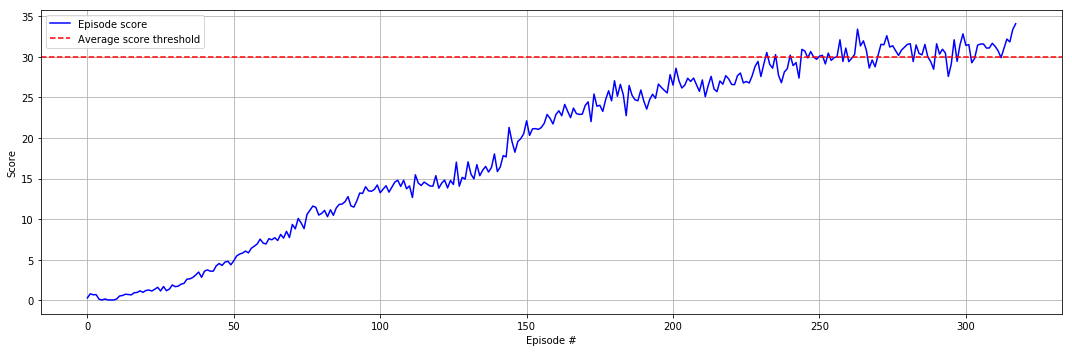

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[15, 5])

ax.plot(scores, "-", c="blue")
ax.set_xlabel("Episode #")
ax.set_ylabel("Score")
ax.grid(which="major")
plt.axhline(y=30, color='r', linestyle='dashed')
ax.legend(["Episode score", "Average score threshold"])

fig.tight_layout()
fig.savefig("multiagent_scores.png")

#### Watch a smart agent

In [15]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0909999979659915


In [ ]:
env.close()